In [1]:
%matplotlib inline
import sys
print(sys.version)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import requests
import io
import scipy
# Update the matplotlib configuration parameters:
mpl.rcParams.update({'font.size': 18, 'font.family': 'serif', 'xtick.major.pad' : 5, 'ytick.major.pad' : 5})


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme()

import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression


3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]


In [2]:
# Loading our data in its raw form

urlGam = "https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX" # Make sure the url is the raw version of the file on GitHub
downloadGam = requests.get(urlGam).content
GamRaw = pd.read_csv(io.StringIO(downloadGam.decode('utf-8')))

urlNeut = "https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46" # Make sure the url is the raw version of the file on GitHub
downloadNeut = requests.get(urlNeut).content
NeutRaw = pd.read_csv(io.StringIO(downloadNeut.decode('utf-8')))

In [3]:
# Normalizing Data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(GamRaw)
scaledGam = scaler.transform(GamRaw)
GamNormal = pd.DataFrame(scaledGam, columns=GamRaw.columns)
GamNormal.head()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
0,0.309014,0.500017,0.316455,0.391304,0.0,0.239100,0.571571,0.929306,0.954548,0.011228,0.374372
1,0.137330,0.168001,0.896980,0.391304,0.0,0.664525,0.537218,0.956967,0.966199,0.000418,0.677404
2,0.797621,0.147970,0.527490,0.347826,0.0,0.416199,0.587327,0.958785,0.960309,0.010556,0.305103
3,0.981994,0.664871,0.590116,0.413043,0.0,0.495234,0.658971,0.942428,0.954145,0.002930,0.693429
4,0.546102,0.456917,0.608336,0.434783,0.0,0.547988,0.708769,0.962667,0.961407,0.002104,0.885402


In [4]:
scaler.fit(NeutRaw)
scaledNeut = scaler.transform(NeutRaw)
NeutNormal = pd.DataFrame(scaledNeut, columns=NeutRaw.columns)
NeutNormal.head()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
0,0.277350,0.506336,0.046628,0.050847,0.0,0.065102,1.000000,1.000000,0.845587,0.034378,0.681348
1,0.510501,0.641275,0.129485,0.220339,0.0,0.074894,0.338857,0.918015,0.887481,0.030818,0.883004
2,0.118249,0.458065,0.355208,0.355932,0.2,0.246332,0.483786,0.815185,0.866884,0.019507,0.799575
3,0.516117,0.509907,0.244931,0.288136,0.2,0.134062,0.447837,0.742040,0.734324,0.063638,0.908396
4,0.606277,0.264127,0.193122,0.220339,0.0,0.191992,0.916604,0.689069,0.883198,0.014785,0.944172


In [5]:
# Add a distriction column to the data, to know which is gam and which is neut for later graphing

GamNormal["distinction"] = 1
NeutNormal["distinction"] = 2

In [6]:
plotFrame = pd.concat([GamNormal, NeutNormal])

plotFrame.head(5)

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
0,0.309014,0.500017,0.316455,0.391304,0.0,0.239100,0.571571,0.929306,0.954548,0.011228,0.374372,1
1,0.137330,0.168001,0.896980,0.391304,0.0,0.664525,0.537218,0.956967,0.966199,0.000418,0.677404,1
2,0.797621,0.147970,0.527490,0.347826,0.0,0.416199,0.587327,0.958785,0.960309,0.010556,0.305103,1
3,0.981994,0.664871,0.590116,0.413043,0.0,0.495234,0.658971,0.942428,0.954145,0.002930,0.693429,1
4,0.546102,0.456917,0.608336,0.434783,0.0,0.547988,0.708769,0.962667,0.961407,0.002104,0.885402,1


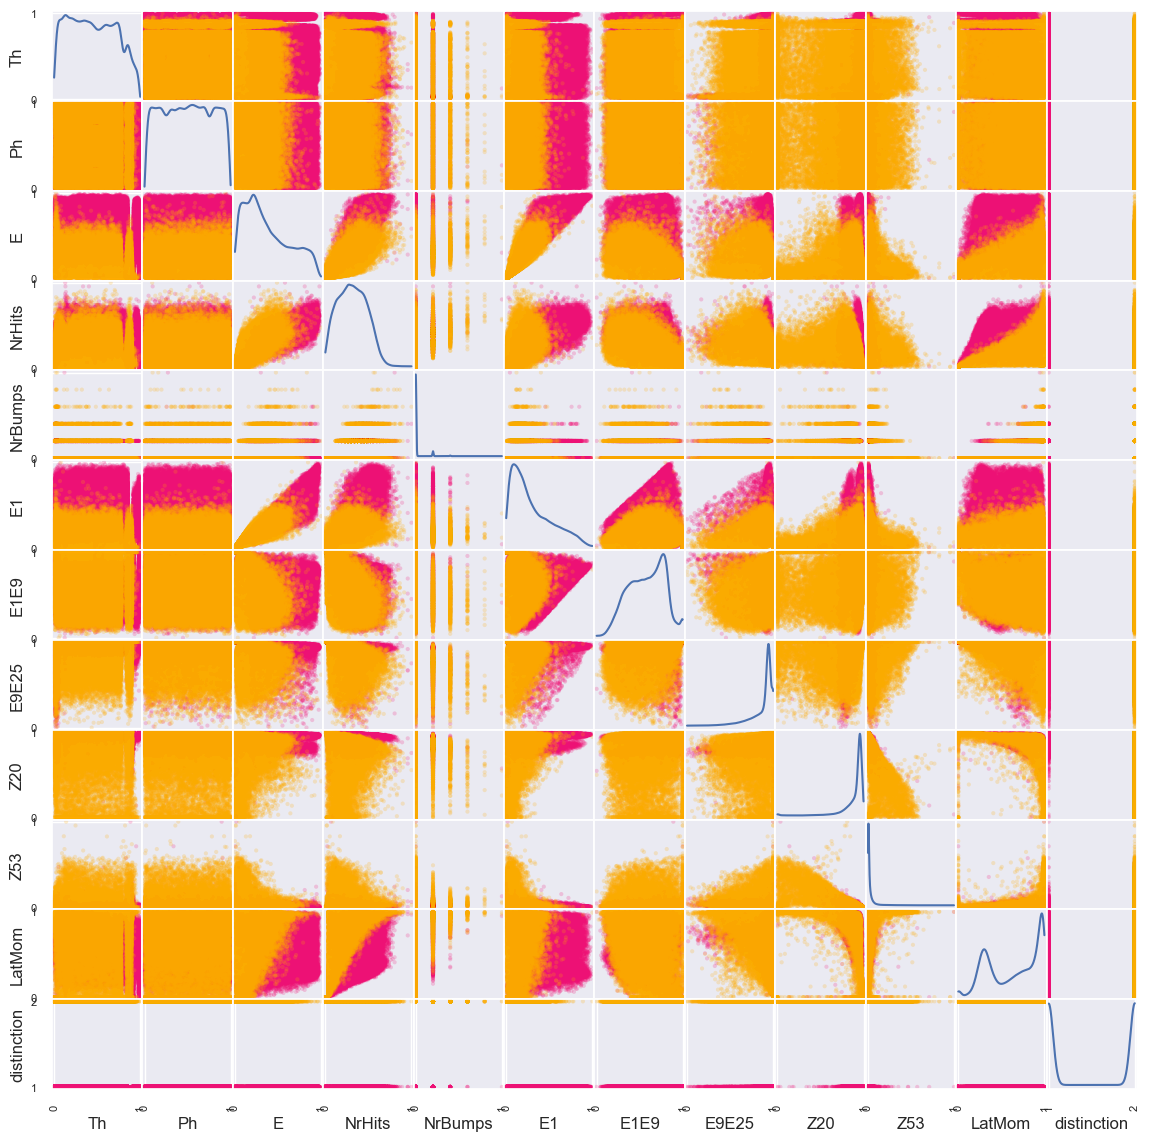

In [7]:
colors = ['#f21175', '#ffab00']

_ = pd.plotting.scatter_matrix(plotFrame, figsize=(14,14), diagonal='kde', alpha=0.2, color=[colors[x-1] for x in list(plotFrame.distinction)])


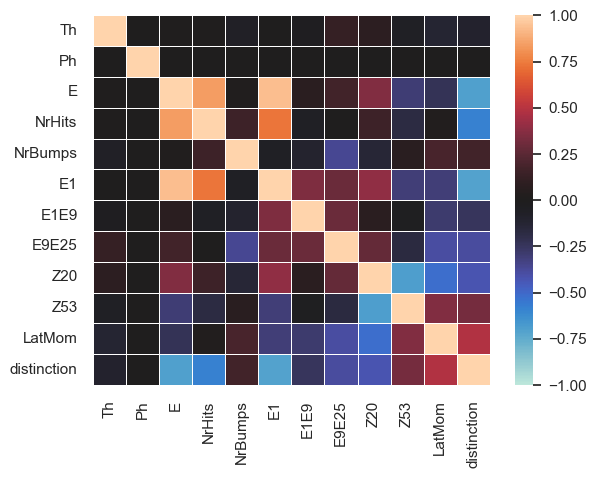

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,distinction
0,0.309014,0.500017,0.316455,0.391304,0.0,0.239100,0.571571,0.929306,0.954548,0.011228,0.374372,1
1,0.137330,0.168001,0.896980,0.391304,0.0,0.664525,0.537218,0.956967,0.966199,0.000418,0.677404,1
2,0.797621,0.147970,0.527490,0.347826,0.0,0.416199,0.587327,0.958785,0.960309,0.010556,0.305103,1
3,0.981994,0.664871,0.590116,0.413043,0.0,0.495234,0.658971,0.942428,0.954145,0.002930,0.693429,1
4,0.546102,0.456917,0.608336,0.434783,0.0,0.547988,0.708769,0.962667,0.961407,0.002104,0.885402,1


In [8]:
#all_col = select_dtypes(include=np.number).columns.tolist()

#plt.figure(figsize=(15,7))

#sns.heatmap(df[all_col].corr(),
#            annot=True,
#            linewidths=0.5,vmin=-1,vmax=1,
#            center=0,
#            cbar=True,)            



df= pd.concat([GamNormal, NeutNormal])

sns.heatmap(plotFrame.corr(),annot=False,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)   

plt.show()

#plotFrame.head()

df.head()

# Preparing data for model

In [9]:
#X = plotFrame.drop(['E1','NrHits','NrBumps','E9E25','Z20', 'Th', 'distinction'], axis=1)
X = plotFrame.drop('distinction', axis=1)
y = plotFrame.pop('distinction')



In [10]:
#Split between training and test samples

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=1, shuffle= True)

X_train.head()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
8063,0.109730,0.114616,0.177392,0.101695,0.0,0.250500,0.955448,0.975040,0.978006,0.013683,0.083757
33413,0.800370,0.724188,0.741535,0.413043,0.0,0.493250,0.456071,0.936847,0.964420,0.003885,0.225526
10640,0.240066,0.329088,0.895755,0.608696,0.0,0.807140,0.728447,0.946410,0.953314,0.008144,0.899615
31227,0.392357,0.520092,0.137191,0.169492,0.0,0.059899,0.253802,0.705666,0.890637,0.046348,0.797454
33395,0.553763,0.129773,0.573403,0.478261,0.0,0.339697,0.383471,0.929681,0.948476,0.000904,0.354931


In [11]:
## Function to create confusion matrix
def Confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision. 
#We care about Recall, this one tells us the number of times it got the answer right
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    #Predicting on train and tests
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    #Accuracy of the model
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    #Recall of the model
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    #Precision of the model
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
    
    return score_list # returning the list with train and test scores

In [13]:
#Bagging the tree

bagging_estimator=BaggingClassifier(random_state=1)
bagging_estimator.fit(X_train,y_train)

BaggingClassifier(random_state=1)

In [14]:
#Seeing the results of bagging
bagging_estimator_score=get_metrics_score(bagging_estimator)


Accuracy on training set :  0.9993915474428547
Accuracy on test set :  0.9913667408487453
Recall on training set :  0.999636927748622
Recall on test set :  0.9904309882875296
Precision on training set :  0.9991422538928477
Precision on test set :  0.9923301119803651


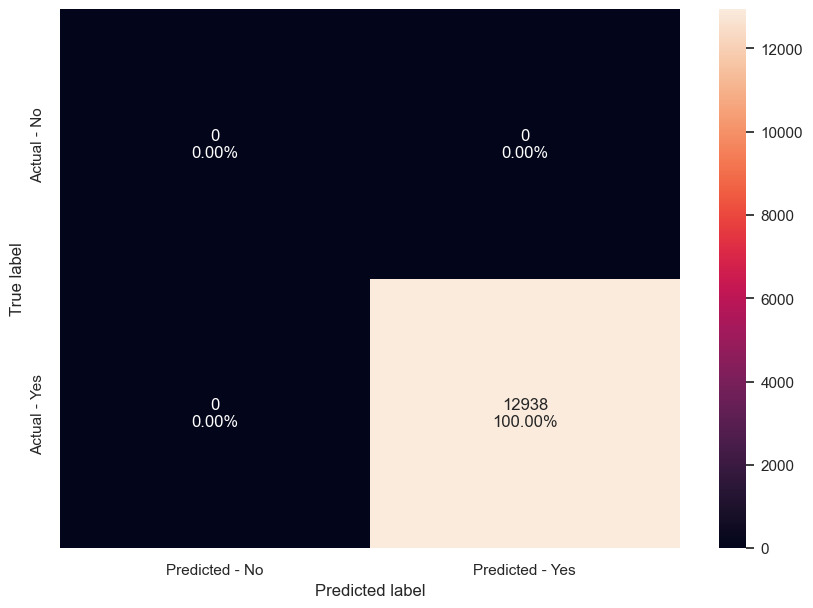

In [15]:
#Confusion matrix for training set

Confusion_matrix(bagging_estimator,y_test)


In [16]:
#Training the random Forest

rf_estimator=RandomForestClassifier(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestClassifier(random_state=1)

In [17]:
#Getting the results of our random forest
rf_estimator_score=get_metrics_score(rf_estimator)


Accuracy on training set :  1.0
Accuracy on test set :  0.9914434809300898
Recall on training set :  1.0
Recall on test set :  0.9885937380387354
Precision on training set :  1.0
Precision on test set :  0.9943024330150908


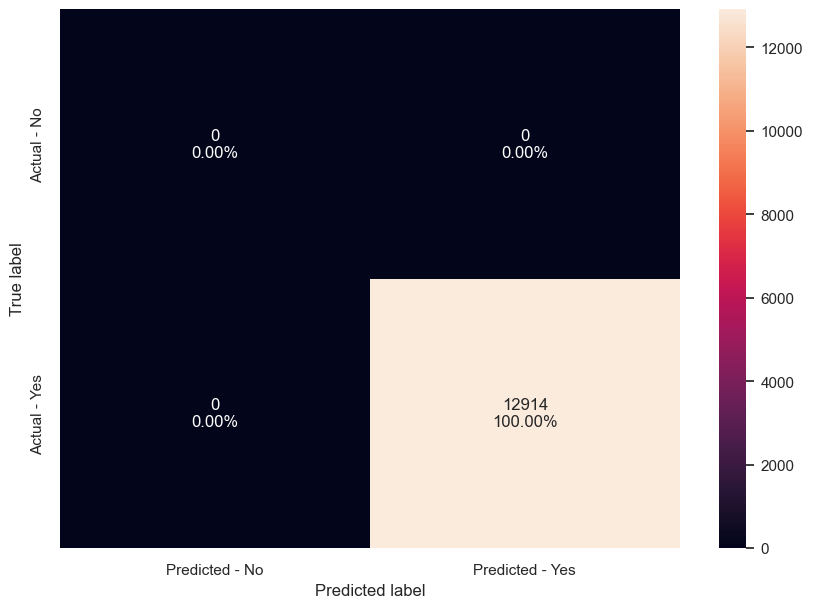

In [18]:
Confusion_matrix(rf_estimator,y_test)
